# EEG analysis of the Relax Protocol with Deep Learning
In this notebook, I am going to analyze EEG signals collected during evening reading sessions for days where I perfomed the Relax Protocol right before the session (relax_protocol_alpha_cleaned.csv) and on days where no protocol was performed (no_protocol_alpha_cleaned.csv)

My hypothesis is that we will see differences between these two types of sessions, specifically on the alpha band, since this is the frequency band most robust to noise in the EEG. 

I collected my own EEG signals using the MW75 Neuro and its  Research Kit.

In this notebook I will cover:
- Use a convolutional neural network to identify if there are differences between the EEG datasets

In 2 separate notebooks I will cover:

- Signal processing and artifact rejection
- Extracting power in the alpha band (the feature of choice)



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [8]:
relax_protocol_alpha = pd.read_csv('data/relax_protocol/features/relax_protocol_alpha_cleaned.csv')
no_protocol_alpha = pd.read_csv('data/relax_protocol/features/no_protocol_alpha_cleaned.csv')

In [9]:
eeg_columns = relax_protocol_alpha.columns
eeg_columns

Index(['Ch1RawEEG', 'Ch2RawEEG', 'Ch3RawEEG', 'Ch4RawEEG', 'Ch5RawEEG',
       'Ch6RawEEG', 'Ch7RawEEG', 'Ch8RawEEG', 'Ch10RawEEG', 'Ch11RawEEG',
       'Ch12RawEEG'],
      dtype='object')

In [10]:
relax_protocol_alpha["has_focus_protocol"] = 1
no_protocol_alpha["has_focus_protocol"] = 0
data = pd.concat([relax_protocol_alpha, no_protocol_alpha], ignore_index=True)


In [11]:
data

,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG,has_focus_protocol
0,3.852366,1.351839,17.864556,1.354578,1.101281,2.241158,3.873075,3.848341,11.808572,6.970382,3.533553,1
1,5.688932,0.910222,19.097158,2.086638,0.997090,1.975207,6.750688,9.369459,6.607489,5.195529,6.279198,1
2,10.342225,3.775390,20.645936,3.457180,35.158715,6.170227,4.754038,6.105202,11.472558,19.150829,10.685146,1
3,21.848683,3.522477,67.380364,19.146327,5.076937,24.908732,4.224065,14.907476,56.992119,34.697014,13.103675,1
4,8.302813,3.173987,16.858043,4.920124,4.189323,7.773439,7.718138,6.635649,6.391343,5.174117,7.412140,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.877941,1.275343,33.478285,0.635542,1.803572,0.997318,8.548996,6.985823,9.944197,9.759315,9.877679,0
1532,0.542360,1.095387,62.673717,1.357057,3.240550,0.212099,6.069939,6.958318,6.837605,18.062459,7.169066,0
1533,0.347890,0.233154,45.300936,0.530864,3.845705,0.491123,5.503666,3.898973,6.860019,15.550546,8.114855,0
1534,1.222517,1.134030,59.451119,1.273111,4.202553,0.803027,6.989572,6.356289,11.424595,72.387919,6.270086,0


In [12]:
X = data[eeg_columns].values
y = data['has_focus_protocol'].values

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Text(0.5, 1.0, 'Scaled alpha for EEG after protocol (first half) and without protocol (second half)')

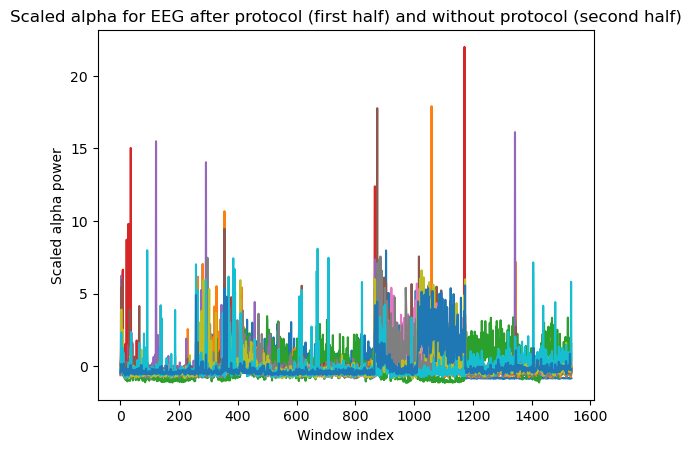

In [14]:
plt.plot(X_scaled)
plt.ylabel("Scaled alpha power")
plt.xlabel("Window index")
plt.title("Scaled alpha for EEG after protocol (first half) and without protocol (second half)")

In [15]:
X_scaled

array([[-0.52875463,  0.15404468, -0.3640336 , ...,  0.04753494,
        -0.25478297, -0.46324338],
       [-0.36279658, -0.20436151, -0.30597878, ..., -0.39542388,
        -0.41939367, -0.28952626],
       [ 0.05769014,  2.12094019, -0.23303222, ...,  0.01891773,
         0.8749059 , -0.01076173],
       ...,
       [-0.84543053, -0.7538535 ,  0.92820405, ..., -0.37391669,
         0.54099365, -0.17338419],
       [-0.76639636, -0.02272449,  1.59466952, ...,  0.01483284,
         5.81243788, -0.29010278],
       [-0.83666772, -0.56436615, -0.36194683, ..., -0.03871673,
         0.40690607, -0.29661051]])

In [16]:
X_cnn = X_scaled.reshape(X_scaled.shape[0], len(eeg_columns), 1)


In [17]:
X_cnn.shape

(1536, 11, 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)


In [19]:
# 7. Build CNN model
model = Sequential([
    Input(shape=(len(eeg_columns), 1)),
    Conv1D(filters=32, kernel_size=2, activation='relu'),    # Input_shape=(channels, 1): num_channels time steps with 1 feature per step
    MaxPooling1D(pool_size=1),                                                   # MaxPooling layer: downsamples the output using a pool size of 1 (no real effect in this case)
    Flatten(),                                                                   # Flattens the output of the previous layer into a 1D vector for the dense layer
    Dense(16, activation='relu'),                                                # Fully connected (Dense) layer with 16 neurons and ReLU activation
    Dropout(0.3),                                                                # Dropout layer: randomly drops 30% of neurons during training to reduce overfitting
    Dense(1, activation='sigmoid')  # binary classification                      # Output layer: single neuron with sigmoid activation for binary classification (stress vs no stress)
])


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6839 - loss: 0.6483 - val_accuracy: 0.8455 - val_loss: 0.4617
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8302 - loss: 0.4472 - val_accuracy: 0.9187 - val_loss: 0.3168
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8896 - loss: 0.3279 - val_accuracy: 0.9309 - val_loss: 0.2509
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9066 - loss: 0.2701 - val_accuracy: 0.9512 - val_loss: 0.2006
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9036 - loss: 0.2502 - val_accuracy: 0.9512 - val_loss: 0.1694
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9155 - loss: 0.2176 - val_accuracy: 0.9512 - val_loss: 0.1523
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - loss: 0.1909 - val_accuracy: 0.9593 - val_loss: 0.1364
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9374 - loss: 0.1773 - val_accuracy: 0.9675 - val_loss:

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {int(accuracy*100)}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1004
Test Accuracy: 96%


This is looking pretty good! I wonder:
- What are the channels that influence the prediction the most. 
- How will it perform with a couple of fresh datasets that I collect this week?

## Evaluating the model

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1004
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9733 - loss: 0.0845 - val_accuracy: 0.9675 - val_loss: 0.0808
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9717 - loss: 0.0977 - val_accuracy: 0.9715 - val_loss: 0.0723
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9609 - loss: 0.1034 - val_accuracy: 0.9675 - val_loss: 0.0768
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9670 - loss: 0.1100 - val_accuracy: 0.9756 - val_loss: 0.0719
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.0832 - val_accuracy: 0.9797 - val_loss: 0.0716
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9668 - loss: 0.0953 - val_accuracy: 0.9756 - val_loss: 0.0708
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9616 - loss: 0.1098 - val_accuracy: 0.9675 - val_loss: 0.0760
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

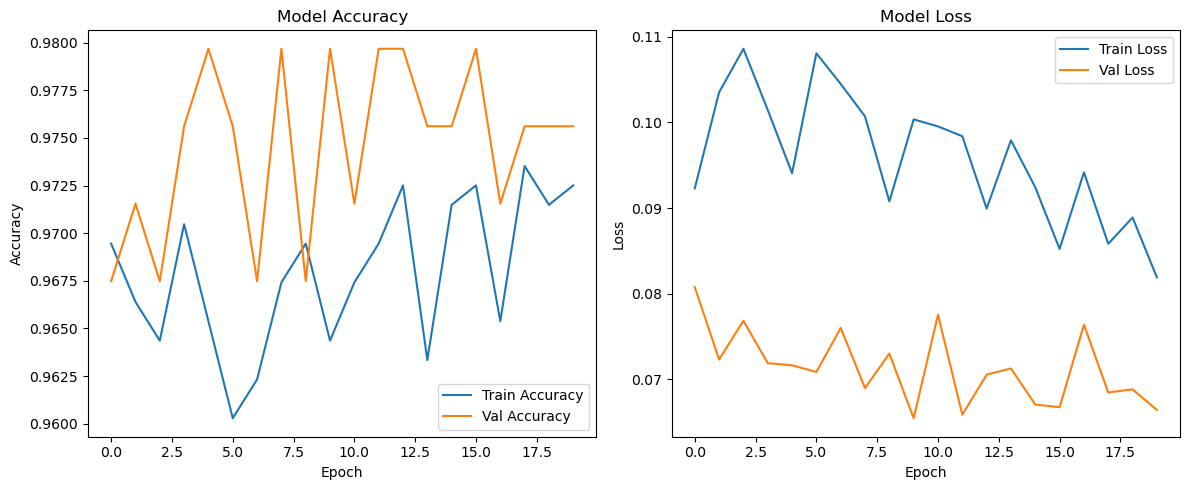

In [23]:
model.evaluate(X_test, y_test)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


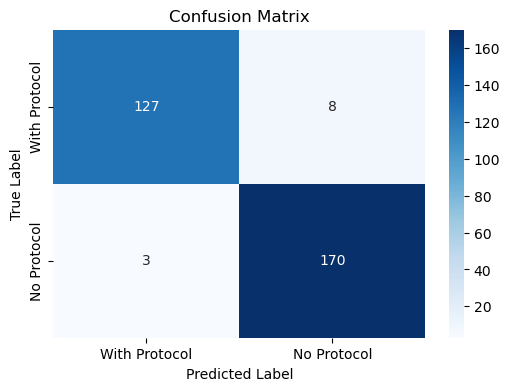

In [24]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['With Protocol', 'No Protocol'], yticklabels=['With Protocol', 'No Protocol'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()